# Topology Optimization of a Solid Body

In [17]:
import pyvista as pv
import numpy as np
from polymesh.examples import stand_vtk
from polymesh import PointCloud
from polymesh import CartesianFrame
from sigmaepsilon import Structure, PointData, SolidMesh
from sigmaepsilon.fem.cells import TET10 as CellData

pd = stand_vtk(read=True)

In [18]:
G = 10.0  # kg
g = 9.81  # m/s2
h = 100.0  # mm
E = 5000.0  # Young's mpdulus
nu = 0.2  # Poisson's ratio

# oc parameters
volume_fraction = 0.7
ftol = 0.9
nIter = 200

In [19]:
# scale model to have the desired height
[[xmin, xmax], [ymin, ymax], [zmin, zmax]] = pd.bounds()
ratio = h / (zmax - zmin)
pc = PointCloud(pd.coords(), frame=pd.frame)
pc.centralize()
pc = PointCloud(pc * ratio, frame=pd.frame)
[[xmin, xmax], [ymin, ymax], [zmin, zmax]] = pc.bounds()
pc.move([0.0, 0.0, -zmin])
[[xmin, xmax], [ymin, ymax], [zmin, zmax]] = pc.bounds()
assert np.abs(zmin) < 1e-12
assert np.isclose(h, zmax - zmin)

In [20]:
coords = pc.show()
topo = pd.topology()

# istoropic material
A = np.array(
    [
        [1, nu, nu, 0, 0, 0],
        [nu, 1, nu, 0, 0, 0],
        [nu, nu, 1, 0, 0, 0],
        [0.0, 0, 0, (1 - nu) / 2, 0, 0],
        [0.0, 0, 0, 0, (1 - nu) / 2, 0],
        [0.0, 0, 0, 0, 0, (1 - nu) / 2],
    ]
) * (E / (1 - nu**2))

# nodal loads
cond = coords[:, 2] >= (zmax - 6)
i = np.where(cond)[0]
nodal_loads = np.zeros((len(coords), 3), dtype=float)
nodal_loads[i, 2] = -(G * g) / len(i)

# nodal supports
cond = coords[:, 2] < 6
i = np.where(cond)[0]
fixity = np.zeros((len(coords), 3), dtype=bool)
fixity[i, :] = True

# pointdata and celldata
GlobalFrame = CartesianFrame(dim=3)
pd = PointData(coords=coords, frame=GlobalFrame, loads=nodal_loads, fixity=fixity)

# cells
cd = CellData(topo=topo, material=A, frames=GlobalFrame)

# mesh
mesh = SolidMesh(pd, cd, frame=GlobalFrame)
structure = Structure(mesh=mesh)

In [21]:
# solve
structure.linear_static_analysis()
dofsol = structure.nodal_dof_solution()

# displace mesh
structure.mesh.pd["x"] = coords + dofsol[:, :3]

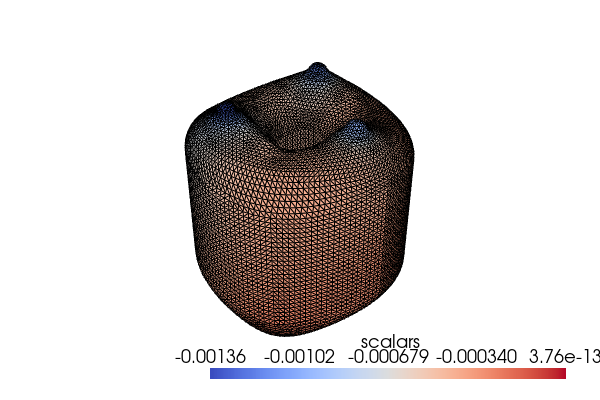

In [22]:
mesh.pvplot(
    notebook=True,
    window_size=(600, 400),
    cmap="coolwarm",
    jupyter_backend="static",
    scalars=dofsol[:, 2],
)

## Optimize

In [23]:
from sigmaepsilon.topopt.oc import maximize_stiffness
from linkeddeepdict import LinkedDeepDict
from tqdm import tqdm

history = LinkedDeepDict(dict(vol=[], obj=[], pen=[], x=[]))

knn = structure.mesh.k_nearest_cell_neighbours(8)

In [24]:
# iteration parameters
OC_params = {
    "p_start": 1.0,  # SIMP penalty factor
    "p_inc": 0.0,
    "q": 0.5,  # smoothing factor
    "vfrac": volume_fraction,
    "dtol": 0.3,  # to control maximum change in the variables
    "miniter": 30,
    "maxiter": 1e12,
}
optimizer = maximize_stiffness(structure, **OC_params)
r = next(optimizer)
history["obj"].append(r.obj)
history["vol"].append(r.vol)
history["pen"].append(r.pen)

In [25]:
for _ in tqdm(range(10)):
    r = next(optimizer)
    history["obj"].append(r.obj)
    history["vol"].append(r.vol)
    history["pen"].append(r.pen)

100%|██████████| 10/10 [03:09<00:00, 18.93s/it]


In [26]:
# iteration parameters
OC_params = {
    "p_start": 1.0,  # SIMP penalty factor
    "p_stop": 3.0,
    "p_inc": 0.2,
    "p_step": 5,
    "q": 0.5,  # smoothing factor
    "vfrac": volume_fraction,
    "dtol": 0.1,  # to control maximum change in the variables
    "miniter": 30,
    "maxiter": 1e12,
}
OC_params["neighbours"] = knn
optimizer = maximize_stiffness(structure, guess=r.x, i_start=r.n + 1, **OC_params)
for _ in tqdm(range(nIter)):
    r = next(optimizer)
    history["obj"].append(r.obj)
    history["vol"].append(r.vol)
    history["pen"].append(r.pen)

100%|██████████| 200/200 [1:02:30<00:00, 18.75s/it]


## Postproc

In [27]:
from polymesh.utils.topology import detach

i = np.where(r.x >= ftol)[0]
coords = mesh.coords()
topo = mesh.topology()
coords, topo = detach(coords, topo[i])

In [28]:
# nodal loads
cond = coords[:, 2] >= (zmax - 6)
i = np.where(cond)[0]
nodal_loads = np.zeros((len(coords), 3), dtype=float)
nodal_loads[i, 2] = -(G * g) / len(i)

# nodal supports
cond = coords[:, 2] < 6
i = np.where(cond)[0]
fixity = np.zeros((len(coords), 3), dtype=bool)
fixity[i, :] = True

# pointdata and celldata
GlobalFrame = CartesianFrame(dim=3)
pd = PointData(coords=coords, frame=GlobalFrame, loads=nodal_loads, fixity=fixity)

# cells
cd = CellData(topo=topo, material=A, frames=GlobalFrame)

# mesh
mesh = SolidMesh(pd, cd, frame=GlobalFrame)
structure = Structure(mesh=mesh)

# solve
structure.linear_static_analysis()
dofsol = structure.nodal_dof_solution()

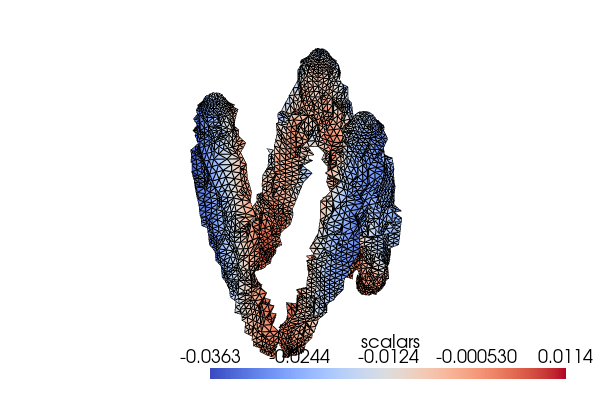

In [29]:
mesh.pvplot(
    notebook=True,
    window_size=(600, 400),
    cmap="coolwarm",
    jupyter_backend="static",
    scalars=dofsol[:, 2],
)

In [30]:
pl = pv.Plotter(notebook=False)
pl = mesh.plot(plotter=pl, cmap="coolwarm", scalars=dofsol[:, 2])